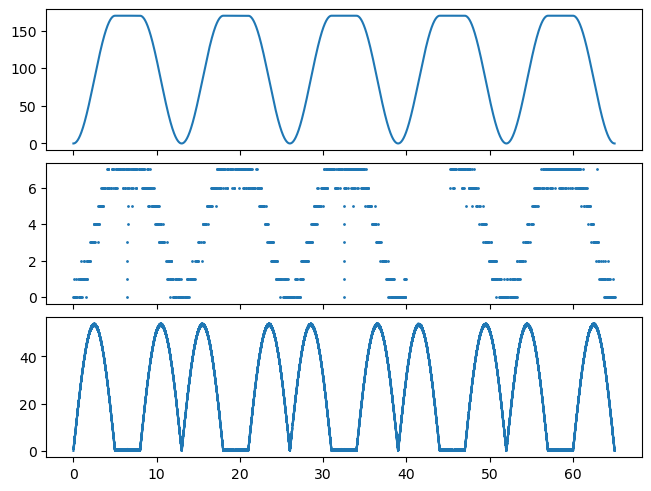

In [1]:
from src.simulate import make_simulated_data
import matplotlib.pyplot as plt
import numpy as np

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

spikes[(time > 40) & (time < 45)] = 0.0

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)


Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/home/edeno/miniconda3/envs/test_hmm/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


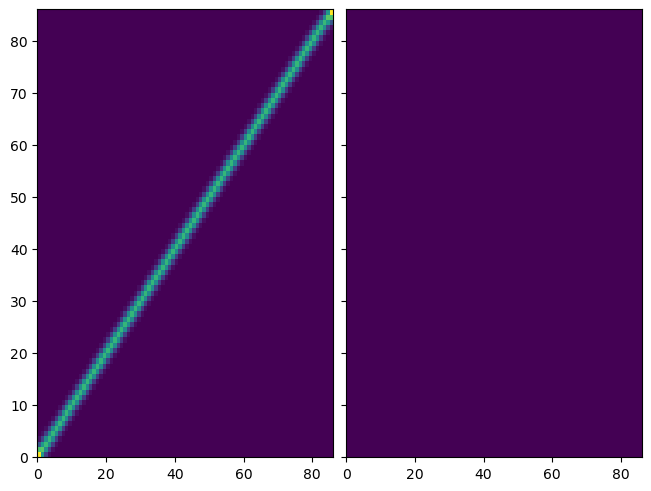

In [2]:
from replay_trajectory_classification import RandomWalk, Environment, Uniform

env = Environment(place_bin_size=2.0).fit_place_grid(position[:, None])
random_walk = RandomWalk().make_state_transition([env])
uniform = Uniform().make_state_transition([env])

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)
axes[0].pcolormesh(random_walk.T)
axes[1].pcolormesh(uniform.T)

In [68]:
# local, no spike, continuous, fragmented

n_states = 4
n_env_bins = env.place_bin_centers_.shape[0]
bin_sizes = [1, 1, n_env_bins, n_env_bins]

state_ind = np.concatenate([ind * np.ones((bin_size,), dtype=int) for ind, bin_size in enumerate(bin_sizes)])
n_state_bins = len(state_ind)

initial_conditions = np.zeros((n_state_bins,))
initial_conditions[state_ind == 0] = 1.0

discrete_state_transitions = np.asarray([[0.9999,   0.0001/3, 0.0001/3, 0.0001/3],
                                         [0.0001/3, 0.9999,   0.0001/3, 0.0001/3],
                                         [0.02/3, 0.02/3, 0.98,   0.02/3],
                                         [0.02/3, 0.02/3, 0.02/3, 0.98],
                                         ])
discrete_state_transitions_per_bin = discrete_state_transitions[np.ix_(state_ind, state_ind)]

continuous_state_transitions = np.zeros((n_state_bins, n_state_bins))

for from_state in range(n_states):
    for to_state in range(n_states):
        
        inds = np.ix_(state_ind==from_state, state_ind==to_state)
        
        if (bin_sizes[from_state] == 1) & (bin_sizes[to_state] == 1):
            # transition from discrete to discrete
            continuous_state_transitions[inds] = 1.0
        elif (bin_sizes[from_state] > 1) & (bin_sizes[to_state] == 1):
            # transition from continuous to discrete
            continuous_state_transitions[inds] = 1.0
        elif (bin_sizes[from_state] == 1) & (bin_sizes[to_state] > 1):
            # transition from discrete to continuous
            continuous_state_transitions[inds] = 1.0 / bin_sizes[to_state] # uniform
        else:
            # transition from continuous to continuous
            if from_state != to_state:
                continuous_state_transitions[inds] = 1.0 / bin_sizes[to_state] # uniform
            else:
                if from_state == 2:
                    continuous_state_transitions[inds] = random_walk.copy()
                elif from_state == 3:
                    continuous_state_transitions[inds] = uniform.copy()
                

In [72]:
 continuous_state_transitions.shape

(174, 174)

In [65]:
(continuous_state_transitions * discrete_state_transitions_per_bin).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

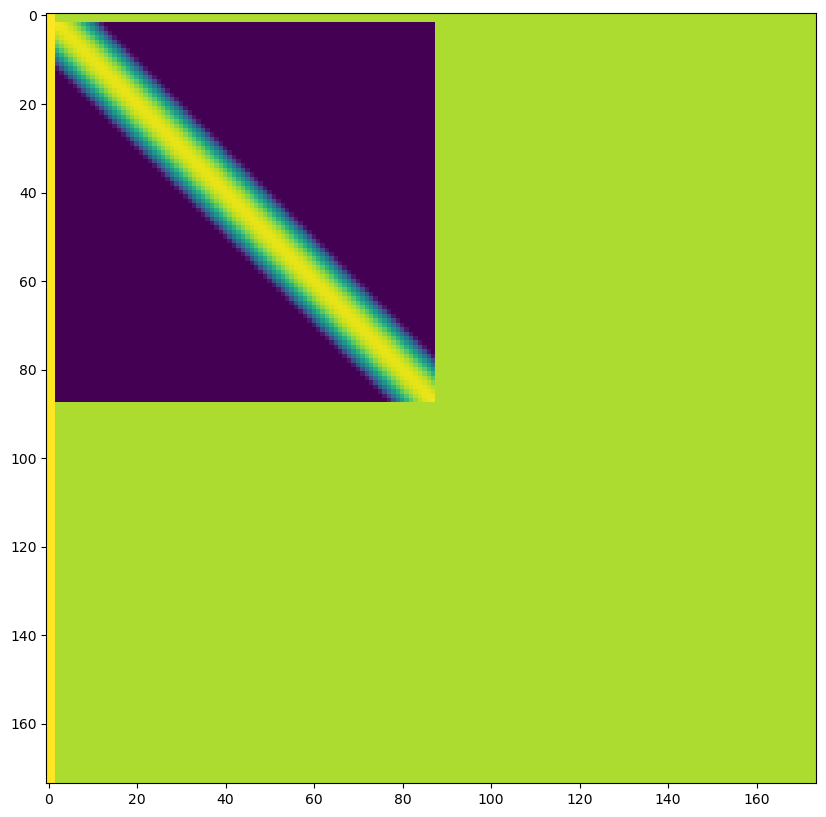

In [66]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log(continuous_state_transitions + np.spacing(1)))

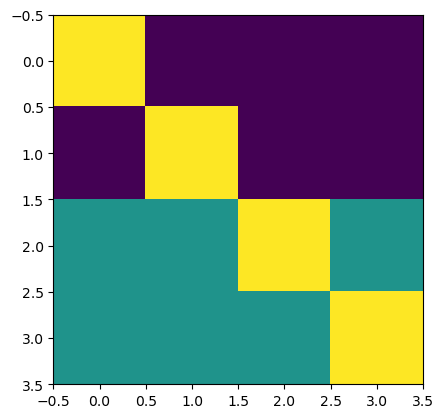

In [6]:
plt.imshow(np.log(discrete_state_transitions + np.spacing(1)))

In [7]:
from patsy import DesignInfo, DesignMatrix, build_design_matrices, dmatrix
import numpy as np
from scipy.optimize import minimize

import jax
import jax.numpy as jnp

from sklearn import linear_model

def fit_regression(design_matrix, weights, spikes, position):

    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity + np.spacing(1)
        )
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)
    
    initial_condition = np.array([np.log(np.average(spikes, weights=weights))])
    initial_condition = np.concatenate([initial_condition, np.zeros(design_matrix.shape[1] - 1)])

    res = minimize(
        neglogp, x0=initial_condition, method="Newton-CG", jac=dlike, hess=dlike2
    )

    return res.x

def make_spline_predict_matrix(
    design_info: DesignInfo, place_bin_centers: np.ndarray
) -> DesignMatrix:
    """Make a design matrix for position bins"""
    predict_data = {}
    predict_data[f"x"] = place_bin_centers
        
    return build_design_matrices([design_info], predict_data)[0]

In [8]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
    poisson_log_likelihood
)

n_time = spikes.shape[0]
is_training = np.ones((n_time,))

df = 6
data = {"x": position}
design_matrix = dmatrix(f"bs(x, df={df})", data)
zero_rates = np.ones_like(spikes) * 1e-5 / sampling_frequency

coefficients = np.stack([fit_regression(design_matrix, is_training.astype(float), s, position) for s in spikes.T], axis=1)

rates = np.exp(design_matrix @ coefficients)

log_likelihood = np.zeros((n_time, n_state_bins))
log_likelihood[:, state_ind==0] = (np.sum(poisson_log_likelihood(spikes, rates), axis=-1))[:, np.newaxis]
log_likelihood[:, state_ind==1] = (np.sum(poisson_log_likelihood(spikes, zero_rates), axis=1))[:, np.newaxis]

predict_matrix = make_spline_predict_matrix(design_matrix.design_info, env.place_bin_centers_)
rates = np.exp(predict_matrix @ coefficients)
log_likelihood_over_bins = (np.sum(poisson_log_likelihood(spikes[:, np.newaxis], rates[np.newaxis]), axis=-1))

log_likelihood[:, state_ind==2] = log_likelihood_over_bins
log_likelihood[:, state_ind==3] = log_likelihood_over_bins

In [9]:
transition_matrix = discrete_state_transitions_per_bin * continuous_state_transitions
# Expectation step
causal_posterior, data_log_likelihood, scaling = forward(
    initial_conditions, log_likelihood, transition_matrix
)

acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

In [10]:
data_log_likelihood

-8802.453888927488

In [11]:
state_probabilities = np.zeros((n_time, n_states))

for ind in range(n_states):
    state_probabilities[:, ind] = acausal_posterior[:, state_ind==ind].sum(axis=1)

In [12]:
position_decode = acausal_posterior[:, np.isin(state_ind, [2, 3])].reshape((-1, 2, n_env_bins)).sum(axis=1)
t, x = np.meshgrid(time, env.place_bin_centers_)

(0.0, 50.0)

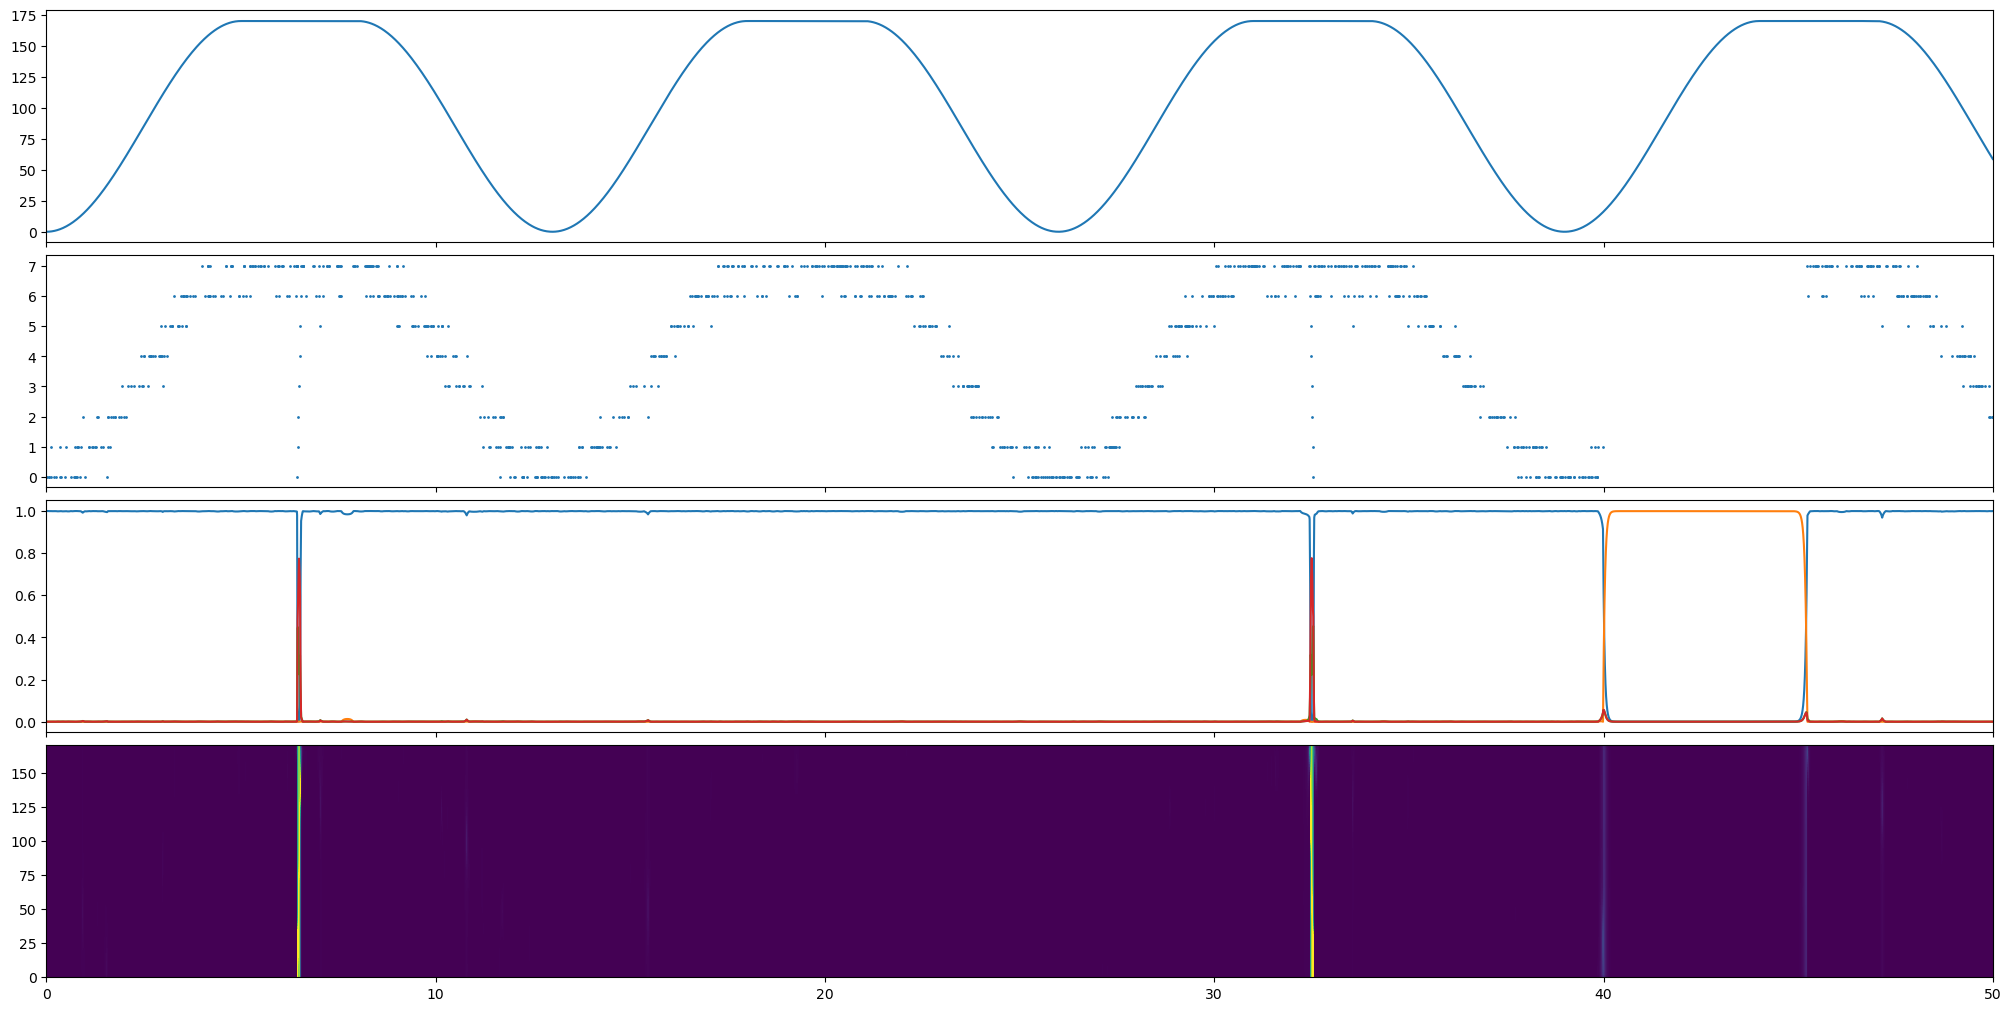

In [13]:
fig, axes = plt.subplots(4, 1, sharex=True, constrained_layout=True, figsize=(20, 10))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, state_probabilities)
axes[3].pcolormesh(t, x, position_decode.T, vmin=0.0, vmax=0.01)
plt.xlim((0, 50))

(0.0, 10.0)

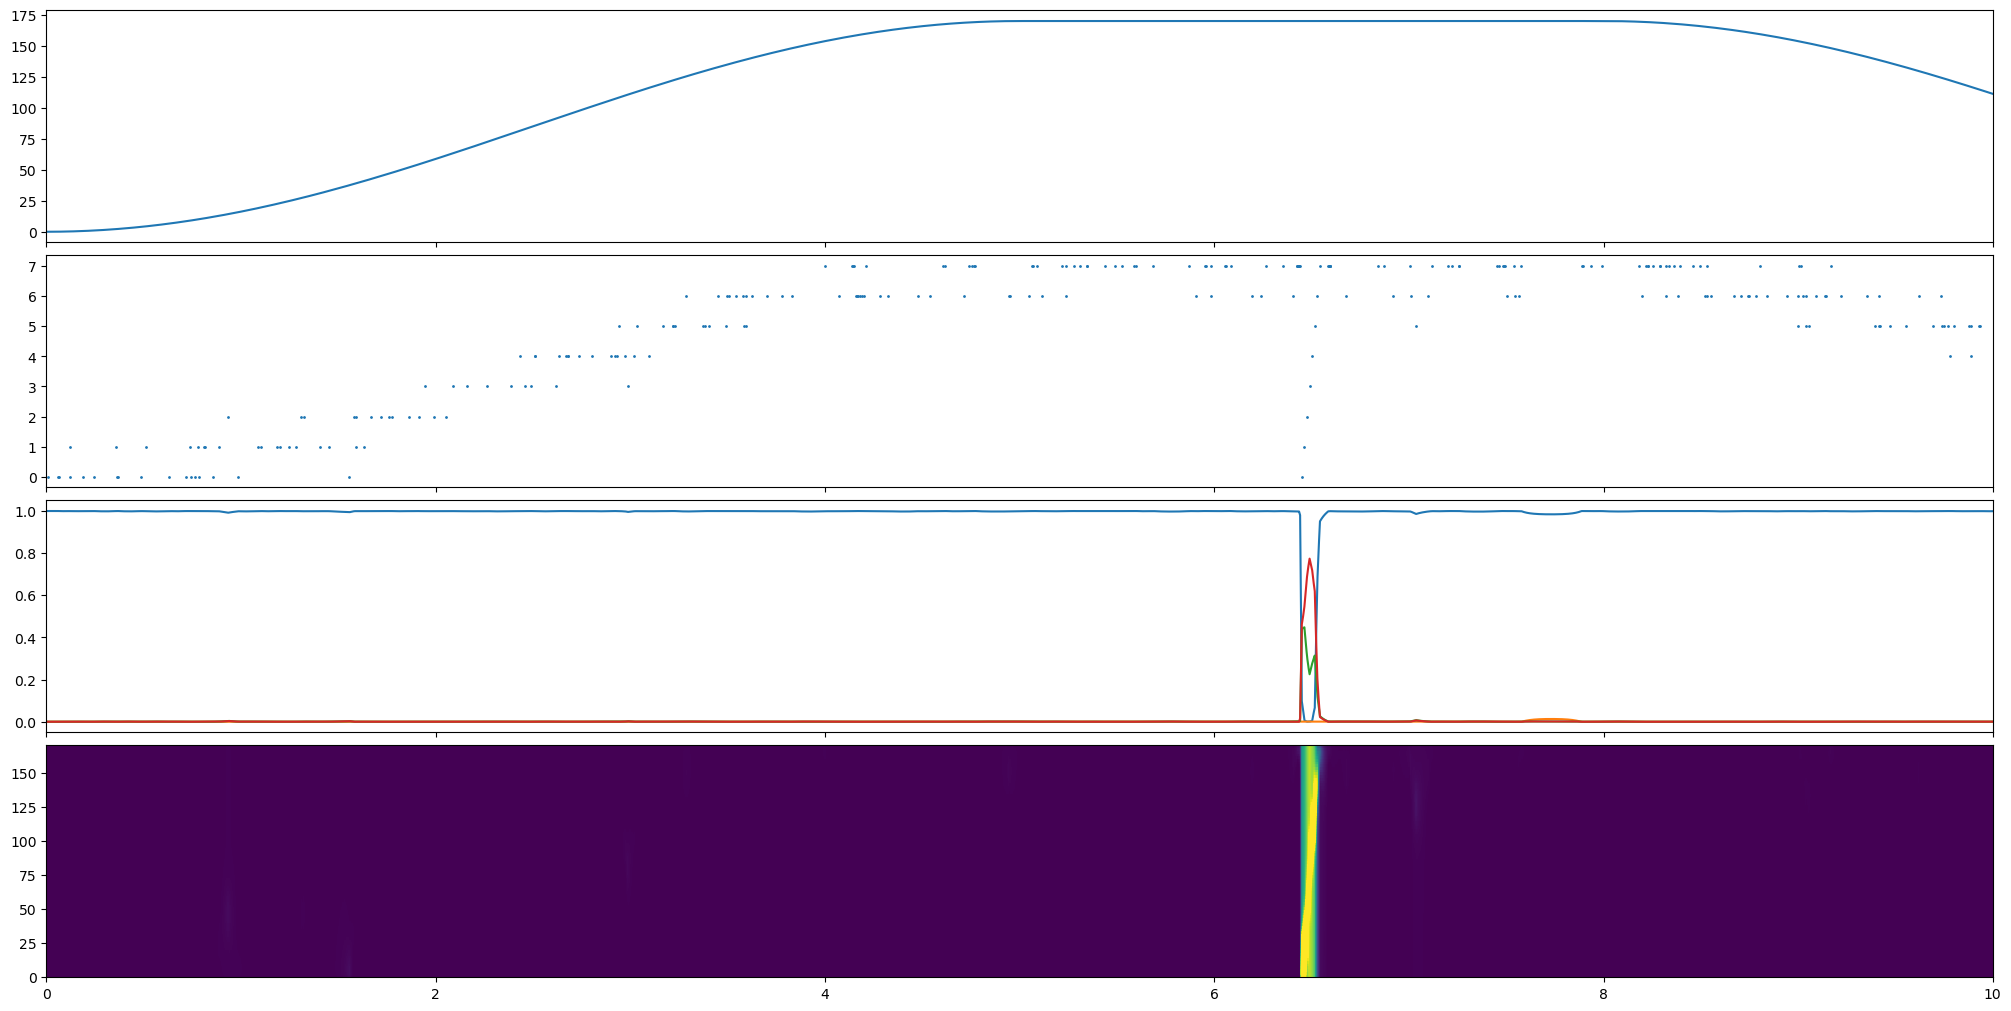

In [14]:
fig, axes = plt.subplots(4, 1, sharex=True, constrained_layout=True, figsize=(20, 10))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, state_probabilities)
axes[3].pcolormesh(t, x, position_decode.T, vmin=0.0, vmax=0.01)
plt.xlim((0, 10))

(15.0, 25.0)

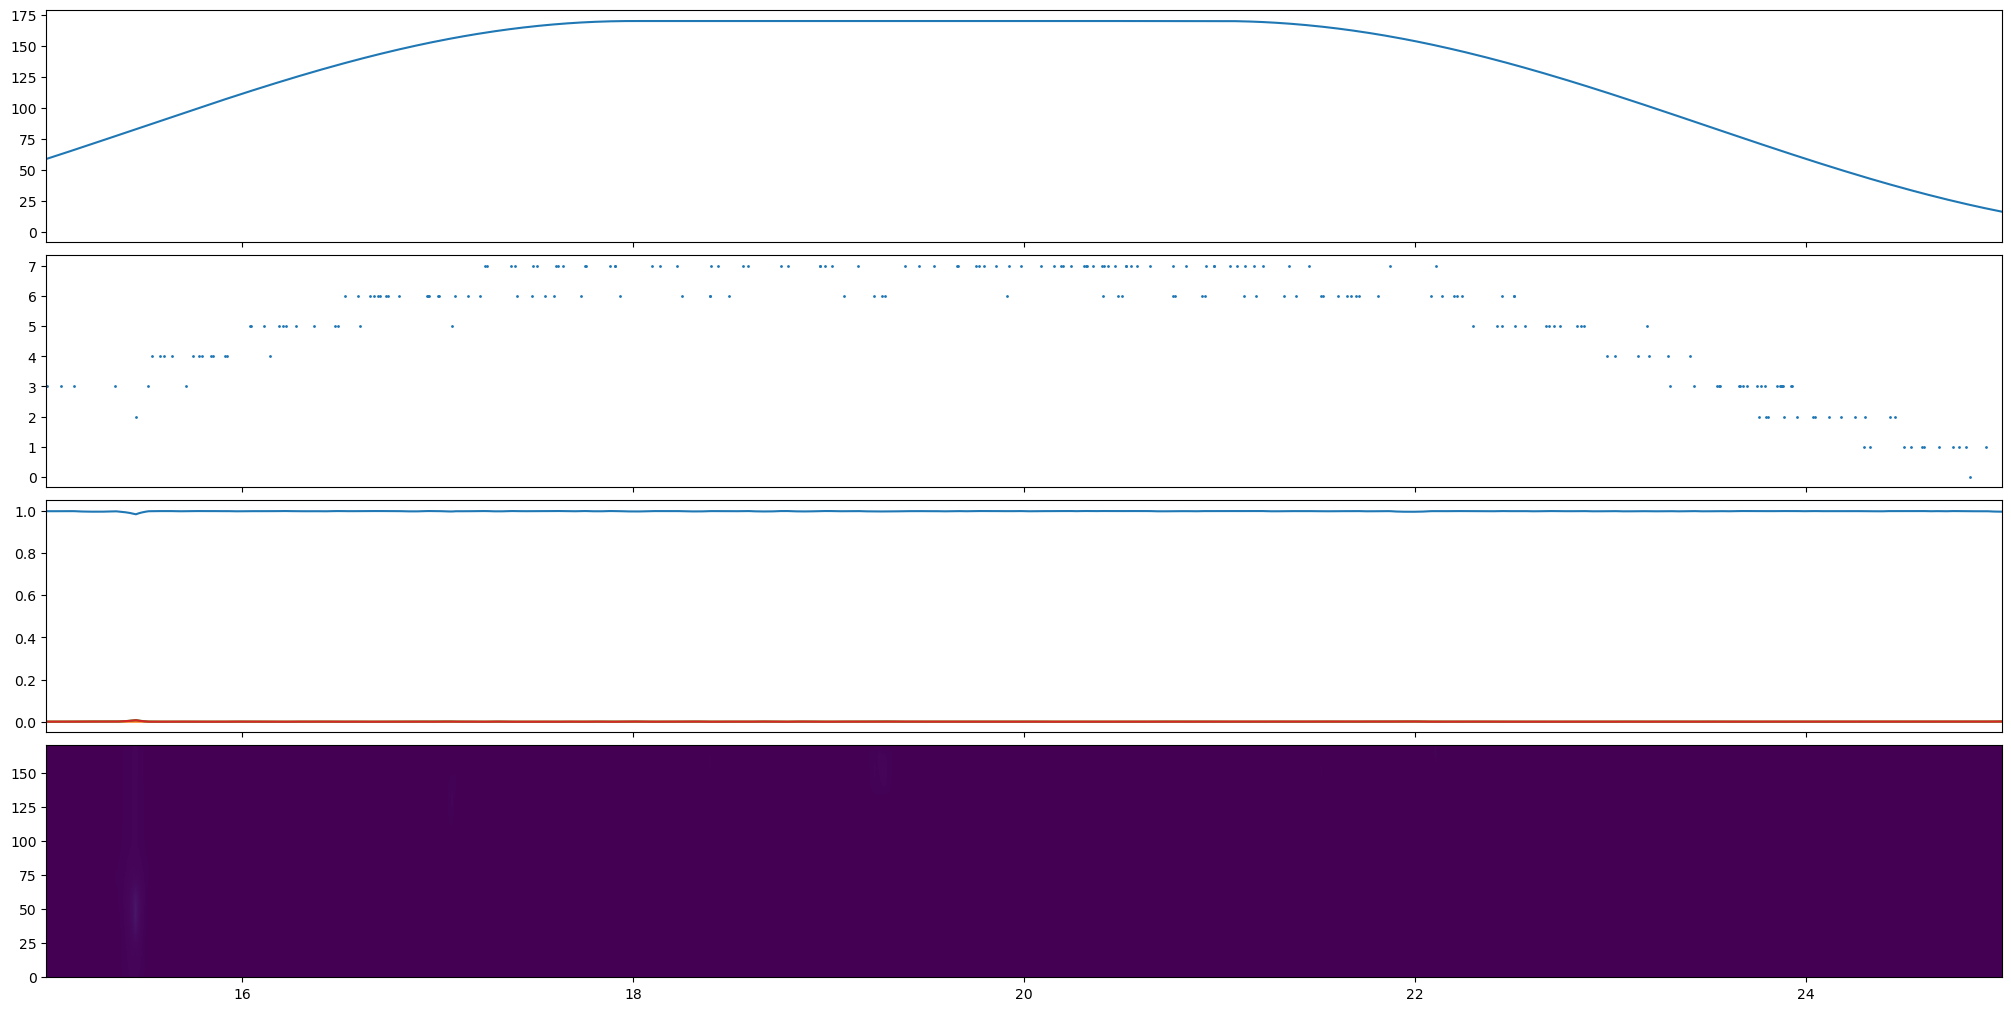

In [15]:
fig, axes = plt.subplots(4, 1, sharex=True, constrained_layout=True, figsize=(20, 10))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, state_probabilities)
axes[3].pcolormesh(t, x, position_decode.T, vmin=0.0, vmax=0.01)
plt.xlim((15, 25))

(30.0, 60.0)

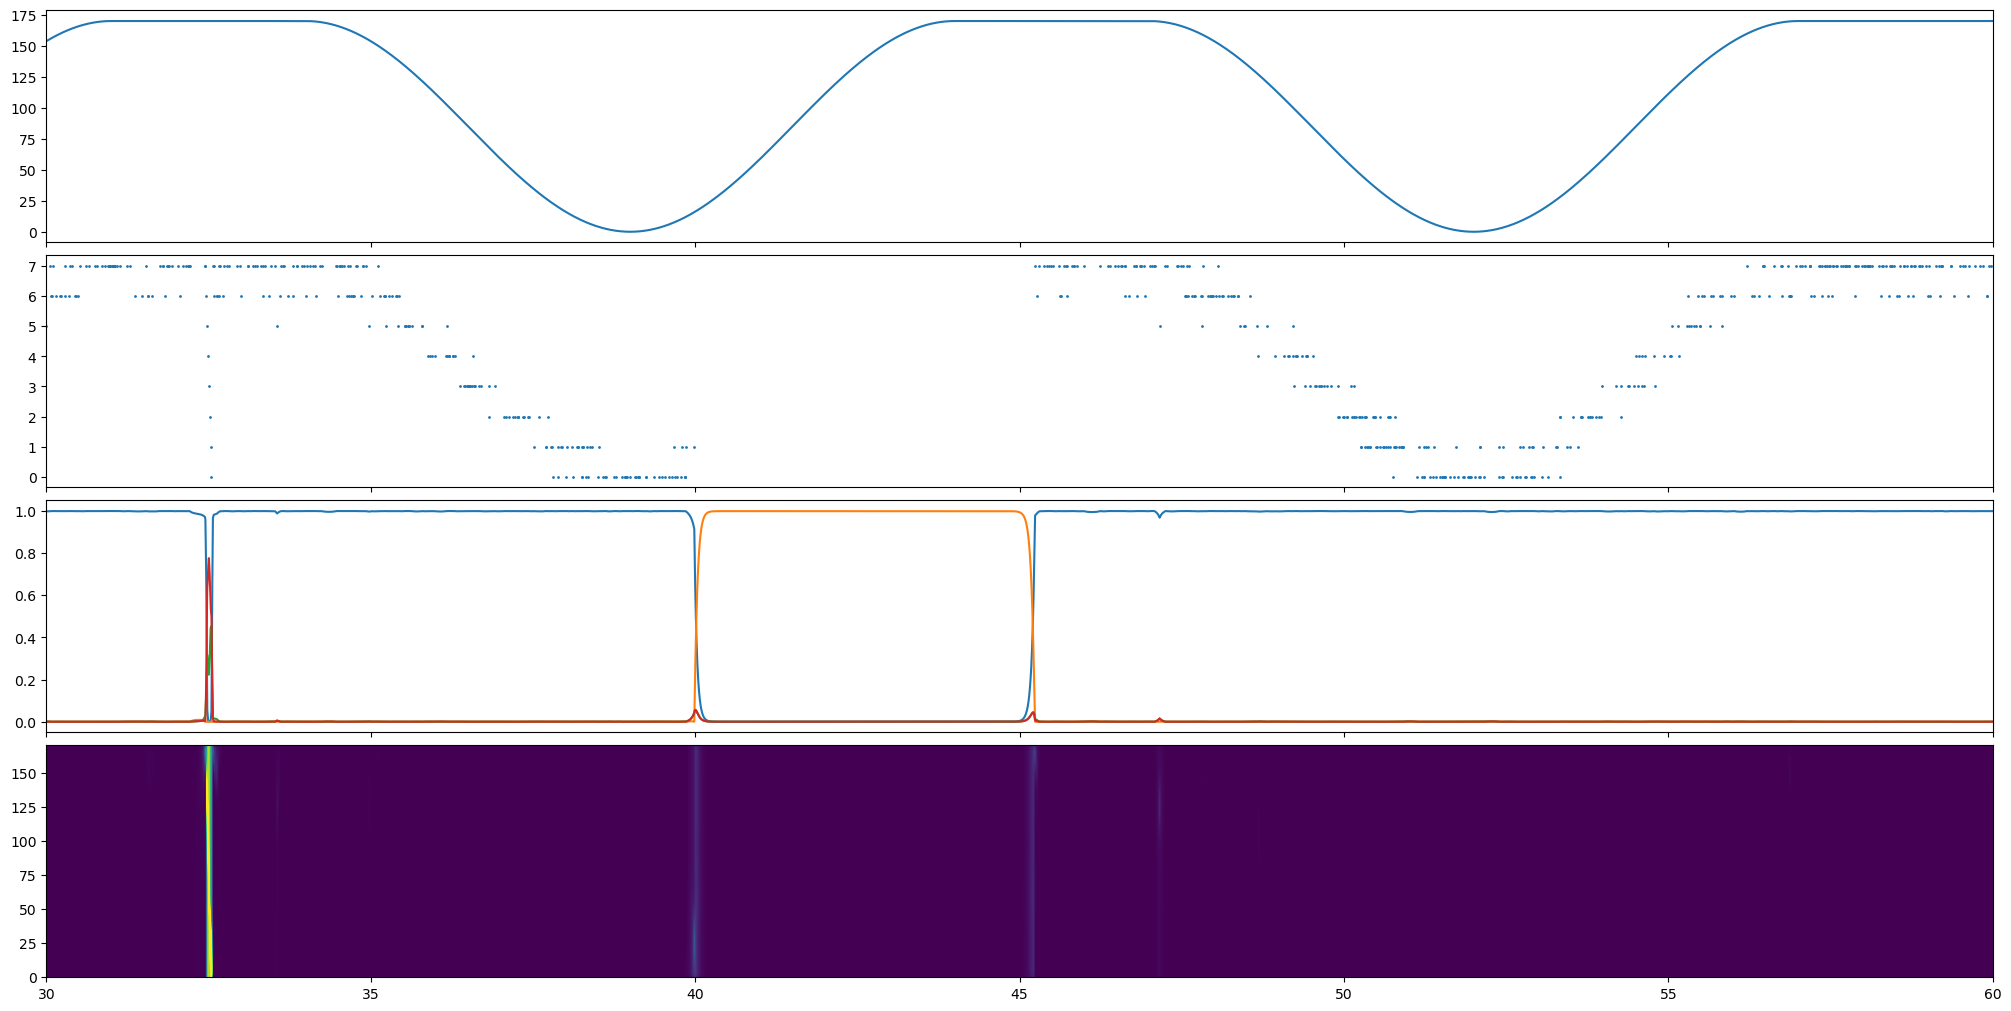

In [16]:
fig, axes = plt.subplots(4, 1, sharex=True, constrained_layout=True, figsize=(20, 10))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, state_probabilities)
axes[3].pcolormesh(t, x, position_decode.T, vmin=0.0, vmax=0.01)
plt.xlim((30, 60))

In [73]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
    poisson_log_likelihood
)

from replay_trajectory_classification.core import scaled_likelihood

tolerance = 1e-4
max_iter = 10

data_log_likelihoods = []
n_iter = 0
converged = False

n_time = spikes.shape[0]
is_training = np.ones((n_time,))
# is_training[: n_time // 2] = 0.0

df = 6
data = {"x": position}
design_matrix = dmatrix(f"bs(x, df={df})", data)
predict_matrix = make_spline_predict_matrix(design_matrix.design_info, env.place_bin_centers_)
zero_rates = np.ones_like(spikes) * 1e-5 / sampling_frequency

discrete_state_transitions = np.asarray([[0.9999,   0.0001/3, 0.0001/3, 0.0001/3],
                                         [0.0001/3, 0.9999,   0.0001/3, 0.0001/3],
                                         [0.02/3, 0.02/3, 0.98,   0.02/3],
                                         [0.02/3, 0.02/3, 0.02/3, 0.98],
                                         ])

continuous_state_transitions = np.zeros((n_state_bins, n_state_bins))

for from_state in range(n_states):
    for to_state in range(n_states):
        
        inds = np.ix_(state_ind==from_state, state_ind==to_state)
        
        if (bin_sizes[from_state] == 1) & (bin_sizes[to_state] == 1):
            # transition from discrete to discrete
            continuous_state_transitions[inds] = 1.0
        elif (bin_sizes[from_state] > 1) & (bin_sizes[to_state] == 1):
            # transition from continuous to discrete
            continuous_state_transitions[inds] = 1.0
        elif (bin_sizes[from_state] == 1) & (bin_sizes[to_state] > 1):
            # transition from discrete to continuous
            continuous_state_transitions[inds] = 1.0 / bin_sizes[to_state] # uniform
        else:
            # transition from continuous to continuous
            if from_state != to_state:
                continuous_state_transitions[inds] = 1.0 / bin_sizes[to_state] # uniform
            else:
                if from_state == 2:
                    continuous_state_transitions[inds] = random_walk.copy()
                elif from_state == 3:
                    continuous_state_transitions[inds] = uniform.copy()
                

causal_state_probabilities = np.zeros((n_time, n_states))
acausal_state_probabilities = np.zeros((n_time, n_states))
state_likelihood = np.zeros((n_time, n_states))

while not converged and (n_iter < max_iter):
    
    # Likelihoods
    print("Likelihoods")
    coefficients = np.stack([fit_regression(design_matrix, is_training.astype(float), s, position) for s in spikes.T], axis=1)

    rates = np.exp(design_matrix @ coefficients)

    log_likelihood = np.zeros((n_time, n_state_bins))
    log_likelihood[:, state_ind==0] = np.sum(poisson_log_likelihood(spikes, rates), axis=-1)[:, np.newaxis]
    log_likelihood[:, state_ind==1] = np.sum(poisson_log_likelihood(spikes, zero_rates), axis=-1)[:, np.newaxis]

    rates = np.exp(predict_matrix @ coefficients)
    log_likelihood_over_bins = np.sum(poisson_log_likelihood(spikes[:, np.newaxis], rates[np.newaxis]), axis=-1)

    log_likelihood[:, state_ind==2] = log_likelihood_over_bins
    log_likelihood[:, state_ind==3] = log_likelihood_over_bins
    
    discrete_state_transitions_per_bin = discrete_state_transitions[np.ix_(state_ind, state_ind)]
    if n_iter == 0:
        transition_matrix = discrete_state_transitions_per_bin * continuous_state_transitions

    # Expectation step
    print("Expectation Step")
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, log_likelihood, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    # Maximization step
    print("Maximization Step")
    for ind in range(n_states):
        is_state = (state_ind == ind)
        causal_state_probabilities[:, ind] = causal_posterior[:, is_state].sum(axis=1)
        acausal_state_probabilities[:, ind] = acausal_posterior[:, is_state].sum(axis=1)
        state_likelihood[:, ind] = np.exp(log_likelihood[:, is_state]).sum(axis=1)

    # discrete_state_transitions = update_transition_matrix_from_correction_smoothing(
    #     causal_state_probabilities,
    #     acausal_state_probabilities,
    #     state_likelihood,
    #     discrete_state_transitions,
    # )
    
    # transition_matrix = update_transition_matrix_from_correction_smoothing(
    #     causal_posterior,
    #     acausal_posterior,
    #     likelihood,
    #     transition_matrix,
    # )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]

    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {data_log_likelihoods[-1]}")

predicted_state = viterbi(initial_conditions, np.exp(log_likelihood), transition_matrix)[0]
position_decode = acausal_posterior[:, np.isin(state_ind, [2, 3])].reshape((-1, 2, n_env_bins)).sum(axis=1)
t, x = np.meshgrid(time, env.place_bin_centers_)

Likelihoods
Expectation Step
Maximization Step
iteration 1, likelihood: -8802.453888927488
Likelihoods
Expectation Step
Maximization Step
iteration 2, likelihood: -8784.89577847768, change: 17.558110449808737
Likelihoods
Expectation Step
Maximization Step
iteration 3, likelihood: -8785.395609804847, change: -0.4998313271680672


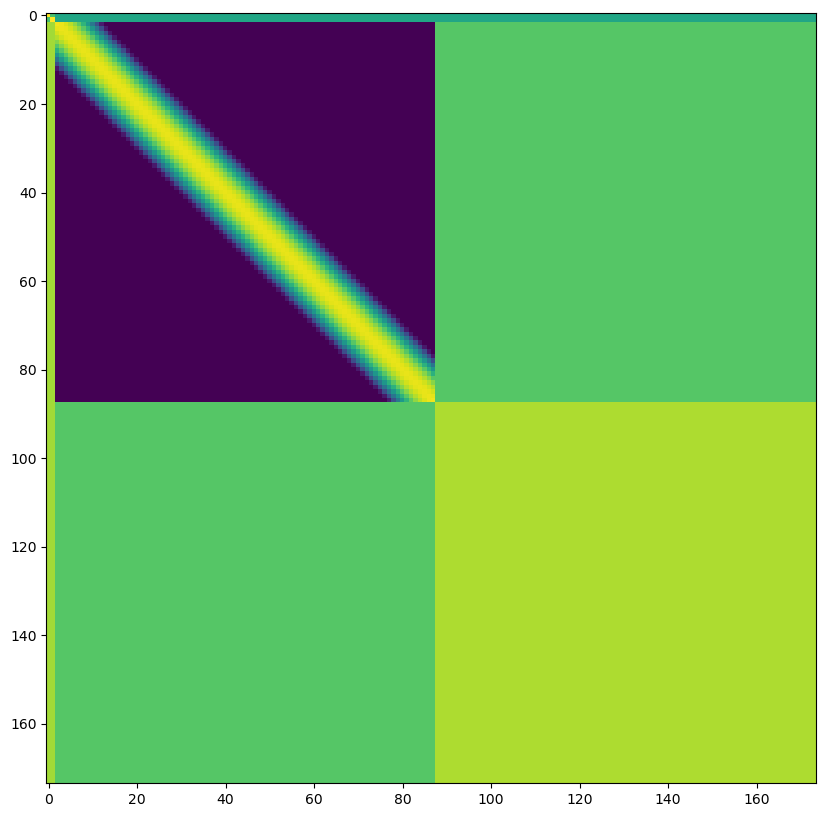

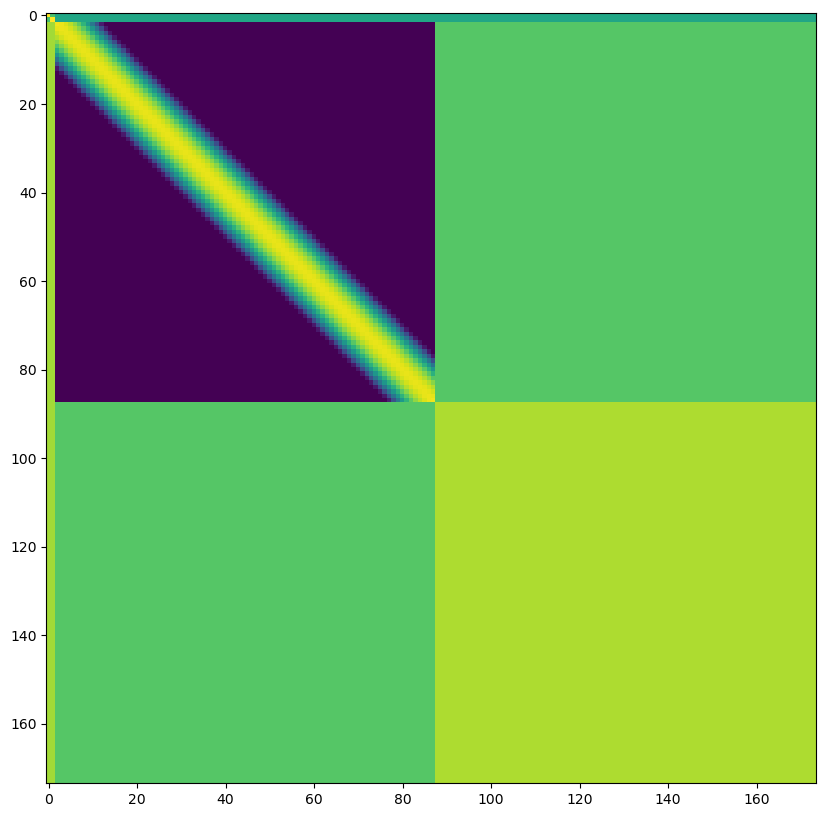

In [74]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log(transition_matrix + np.spacing(1)))

plt.figure(figsize=(10, 10))
plt.imshow(np.log(discrete_state_transitions_per_bin * continuous_state_transitions + np.spacing(1)))

(32.0, 33.0)

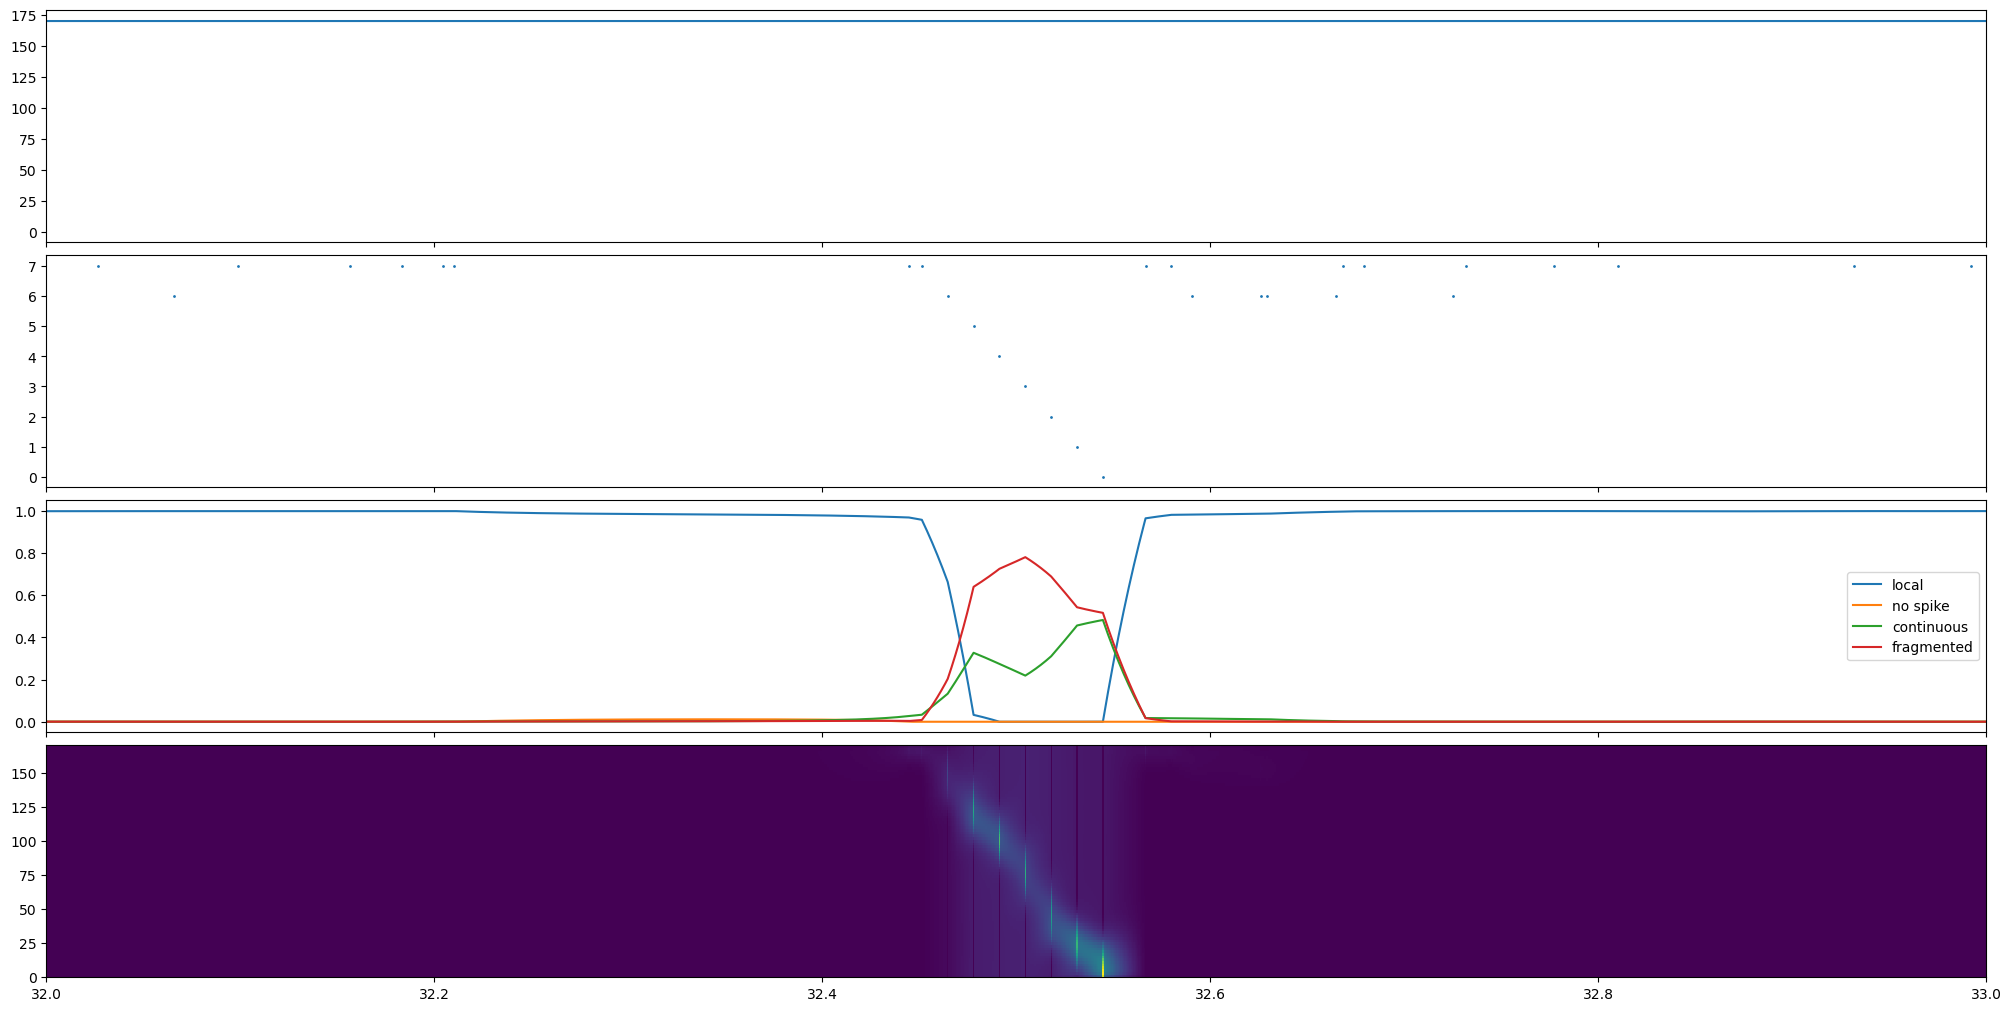

In [79]:
fig, axes = plt.subplots(4, 1, sharex=True, constrained_layout=True, figsize=(20, 10))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
line_objs = axes[2].plot(time, acausal_state_probabilities)
axes[2].legend(line_objs, ['local', 'no spike', 'continuous', 'fragmented'])
axes[3].pcolormesh(t, x, position_decode.T, vmin=0.0, vmax=0.1)
plt.xlim((32, 33))